# How PCA works

There are some excellent notes here from Victor Lavrenko: https://www.youtube.com/playlist?list=PLBv09BD7ez_5_yapAg86Od6JeeypkS4YM.

Assume we have data X in the format where each column represents a piece of data. So for an image dataset each column would represent an image, squashed into a single vector. The dimensions of this dataset are d x n, where d is the number of dimensions in the dataset (e.g. # of pixels in an image), and n is the number of datapoints.

The steps are as follows:
- Normalise the data by subtracting the mean and scaling such that the variance of the data to one. These calculations are performed per row on the attributes of the dataset that give the values of the data per dimension. So mu and sigma are vectors of dimension d, and the data is transformed via X' = (X - mu) / sigma
- Compute the covariance matrix, Sigma. Given that the data has been normalised, so that each attribute has mean zero, this calculation just averages the product of attributes, for each attribute pair, across the data set. The covariance matrix is symmetrical so that only half the matrix needs to be calculated, and the remainder can be copied
- Calculate the Eigenvectors and Eigenvalues of the covariance matrix. The EIgenvectors define a d-dimensional space in which the dimensions (the Eigenvectors) are orthogonal. We can translate each datapoint in X' to Y' by computing the dot product of X' with each Eigenvector in turn. The Eigenvectors can be interpreted as the directions in which the data shows the maximum variance
- Decide on the number of Eigenvectors to use in the reduced representation of the data, m. This can be set by considering a minimum level of variance to maintain; since the Eigenvalues give the variance for each dimension, we can calculate the cumulative variance as a % value and compare this to the threshold
- Once we have m, we can re-construct the data as the sumproduct of the new data coordinates and the Eigenvectors



# Implementing PCA

Do this in two steps as below. The first function applies the PCA decomposition to get the Eigenvalues and Eigenvectors. Given this, the second function can return a reduced representation of the original data, using m << d dimensions. If we excuse the use of libraries for linear algebra and matrix multiplication, it isn't much code.

In [232]:
%reset - f

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  -, please run `%reset?` for details
Don't know how to reset  f, please run `%reset?` for details


In [233]:
import numpy as np


def get_pca(X):
    """
    inputs:     X
    outputs:    mu, sigma, X_norm, evalues, evectors
    X         - data in numpy 2d array format, dims of d x n
    mu, sigma - mean, stdev of data used to normalise it
    X_norm    - normalised data such that each attribute has mean 0 and variance 1
    evalues   - Eigen values of covar
    evectors  - Eigen vectors of covar
    """
    # Normalise the data by subtracting the mean and setting the variance of the data to one
    # These calculations are performed per row on the attributes of the dataset that give the values of the data per dimension
    # So mu and sigma are vectors of dimension d, and the data is transformed via X' = (X - mu) / sigma
    # note extra term in divisor so that zero values in X do not cause x/0 issues - TBC best way to deal eith this
    d = X.shape[0]
    mu = np.mean(X, axis=1)
    sigma = np.std(X, axis=1)
    X_norm = (X - np.expand_dims(mu, axis=1)) / (np.expand_dims(sigma, axis=1) + (np.expand_dims(sigma, axis=1)==0)*1)

    # Compute the covariance matrix, Sigma.
    # Given that the data has been normalised, so that each attribute has mean zero,
    # ...this calculation just averages the product of attributes,
    # ...for each attribute pair, across the data set
    # The covariance matrix is symmetrical so that only half the matrix needs to be calculated,
    # ...and the remainder can be copied
    covar = np.zeros((d, d))
    for i in range(d):
        for j in range(i, d):
            covar[i, j] = np.mean(X_norm[i, :] * X_norm[j, :])
            covar[j, i] = covar[i, j]

    # Calculate the Eigenvectors and Eigenvalues of the covariance matrix
    evalues, evectors = np.linalg.eig(covar)
    
    # Filter the real components if required - can be introduced by precision issues e.g.
    # https://stackoverflow.com/questions/8765310/scipy-linalg-eig-return-complex-eigenvalues-for-covariance-matrix
    if np.iscomplexobj(evalues):
        evalues, evectors = evalues.real, evectors.real
    
    return (mu, sigma, X_norm, evalues, evectors)


def get_reduced_pca_representation(mu, sigma, X_norm, evalues, evectors, m):
    """
    inputs: mu, sigma, X_norm, evalues, evectors, m
    output: X_red
    m       number of (reduced) dimensions on which to reconstruct the data using the Eigenvectors
    X_red   the original data reconstructed from the m leading Eigenvectors
    """
    # compute Y_norm as the coordinates of the normalised data in the Eigenvector space (the first m)
    # this is a dot product of each point on each Eigenvector
    Y_norm_red = np.transpose(np.transpose(X_norm) @ evectors[:, :m])

    # compute the reduced normalised projection into the original space
    X_norm_red = evectors[:, :m] @ Y_norm_red

    # undo the normalisation
    X_red = X_norm_red * \
        np.expand_dims(sigma, axis=1) + np.expand_dims(mu, axis=1)

    return X_red


# Eigen faces

Try the Olivett faces dataset available within scikit learn: https://scikit-learn.org/0.19/datasets/olivetti_faces.html

In [234]:
from sklearn import datasets

print(datasets.fetch_olivetti_faces().DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

First use the PCA function defined above to extract the Eigenvalues and Eigenvectors. This takes a few minutes.

In [235]:
X = np.transpose(datasets.fetch_olivetti_faces().data)
print(f'Dimensions of dataset: {X.shape}')
print(f'Number of images     : {X.shape[1]}')
mu, sigma, X_norm, evalues, evectors = get_pca(X)

Dimensions of dataset: (4096, 400)
Number of images     : 400


## What does the mu-face and Eigenvectors look like?

Before we apply PCA to reduce the dimensionality of the dataset, it's useful to visualise the mean of the dataset. We can use imshow from matplotlib to do this. Note that since the mu vector is 1-d, we need to shape it into 64 x 64 dimensions first. 

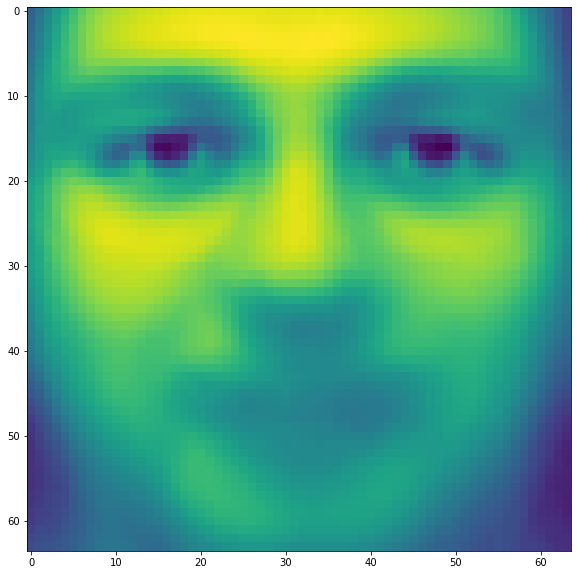

In [236]:
from matplotlib.pyplot import imshow

imshow(mu.reshape((64, 64)))

Similarly we can view the first 5 Eigenvectors. Add a function to display the images as we'll use this a few times.

In [237]:
from matplotlib import pyplot as plt


def display_images_in_grid(m, n, fig_size, img_dict, reshape_size, xlabel,
                           ylabel):
    """
    display grid of images
    img_dict is dictionary mapping tuple of row-col pairs to 1-d images to be unrolled
    """
    fig, ax = plt.subplots(m, n, figsize=fig_size)
    fig.subplots_adjust(hspace=0, wspace=0)

    if m == 1:
        for i in range(m):
            for j in range(n):
                ax[j].xaxis.set_major_locator(plt.NullLocator())
                ax[j].yaxis.set_major_locator(plt.NullLocator())
                ax[j].imshow(img_dict[(i, j)].reshape(reshape_size),
                             cmap="bone")
    else:
        for i in range(m):
            for j in range(n):
                ax[i, j].xaxis.set_major_locator(plt.NullLocator())
                ax[i, j].yaxis.set_major_locator(plt.NullLocator())
                ax[i, j].imshow(img_dict[(i, j)].reshape(reshape_size),
                                cmap="bone")

    fig.supxlabel(xlabel)
    fig.supylabel(ylabel)

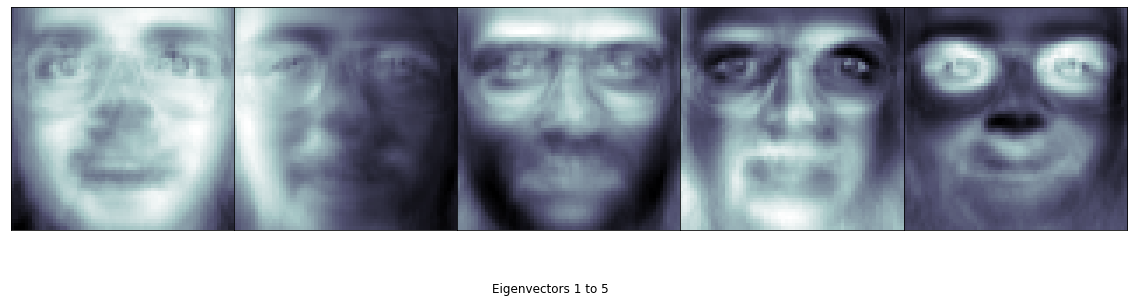

In [238]:
display_images_in_grid(m=1,
                       n=5,
                       fig_size=(20, 5),
                       img_dict={(0, j): evectors[:, j]
                                 for j in range(5)},
                       reshape_size=(64, 64),
                       xlabel='Eigenvectors 1 to 5',
                       ylabel='')

## How many dimensions do we need?

The original data has dimensions 64 * 64 = 4096. How much can we reduce this if we use the Eigenvector space? It turns out, quite a bit! In the images below each row represents a given data point. The left most one is the original, then we have the reduced representation using, 5, 10, 20, 50 and 100 dimensions.

Very interesting to see how the images progress as you add more Eigenvectors in. At 100 there is certainly decent recognition, which is lot less than 4096! It seems to depend on the face. For some, where there is perhaps a less frequent feature, such as a moustache, it takes a little more to get to the recognition stage.

In [239]:
reduced_dims = [5, 10, 20, 50, 100]
X_reduced = [
    get_reduced_pca_representation(mu, sigma, X_norm, evalues, evectors, m=d)
    for d in reduced_dims
]

X_orig_plus_reduced = [X] + X_reduced

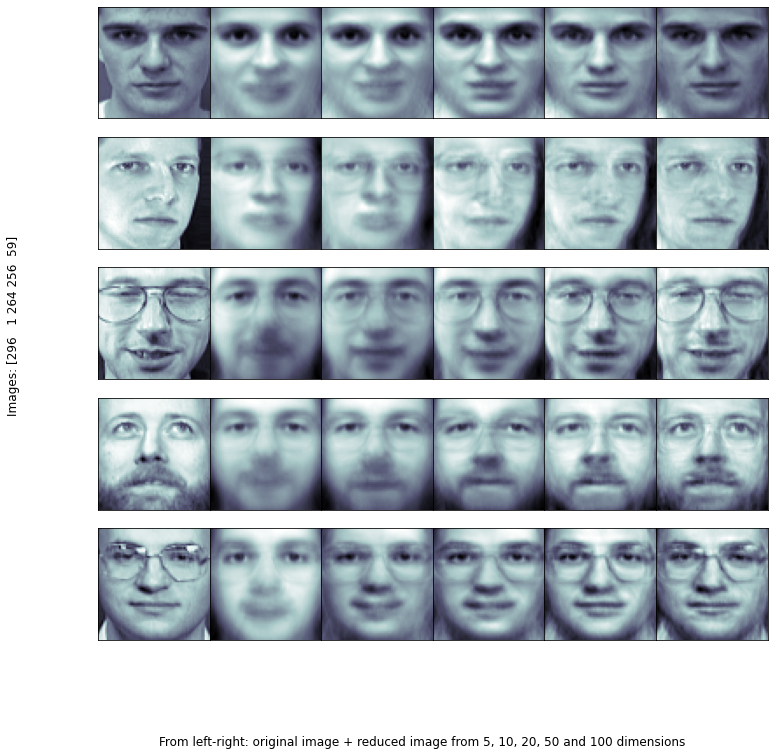

In [240]:
# take 5 random ones from the 400
images_to_view = np.random.choice(400, 5)
images_to_view_grid_dict = {(i, j): X_orig_plus_reduced[j][:,
                                                           images_to_view[i]]
                            for i in range(5) for j in range(6)}

display_images_in_grid(
    m=5,
    n=6,
    fig_size=(12, 12),
    img_dict=images_to_view_grid_dict,
    reshape_size=(64, 64),
    xlabel='From left-right: original image + reduced image from 5, 10, 20, 50 and 100 dimensions',
    ylabel=f'Images: {images_to_view}')

The cumulative sum of the first n Eigenvalues gives the variance that can be explained by the first n Eigenvectors. The sequences above suggest that we can attain a reasonable, reduced representation with 100 Eigenvectors. This is consistent with the plot below, that demonstrate a variance of 94% can be explained this way. 

total variance explained with 100/4096 Eigenvectors: 94%


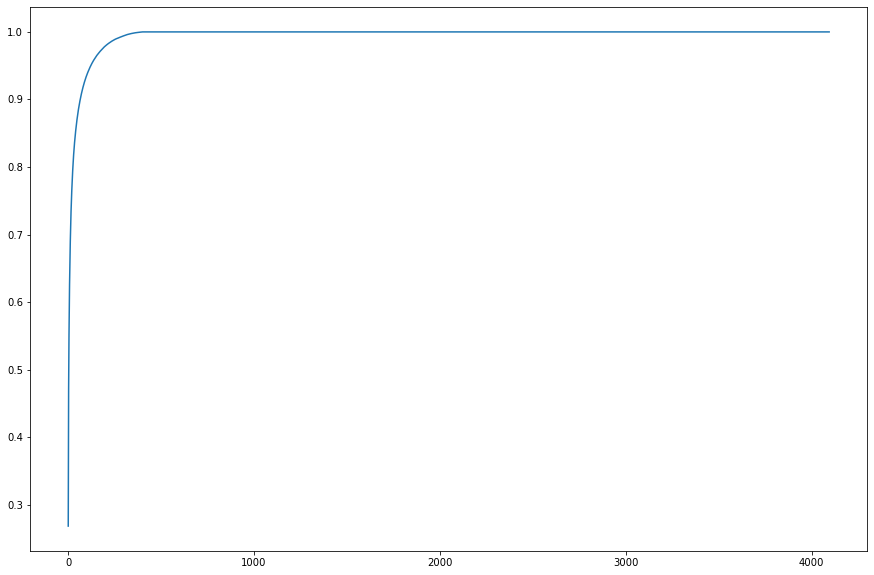

In [241]:
evalues_cum = evalues.cumsum()
evalues_cum_norm = evalues_cum / max(evalues_cum) # equivalently the number of dimensions
print(
    f'total variance explained with 100/4096 Eigenvectors: {evalues_cum_norm[99]:.0%}'
)

plt.plot(evalues_cum_norm)

## Rotate some faces; what happens to the Eigenvectors?

In the Olivetti dataset the faces are oriented, for the most part, in the same direction i.e. from the top, eyes, nose and mouth. What if we randomly rotated the images by 0, 90, 180, 270 degrees? Let's see.....

In [242]:
for i in range(X.shape[1]):
    img_arr = X[:, i].reshape((64, 64))
    num_rot = np.random.choice(4)
    for k in range(num_rot):
        img_arr = np.rot90(img_arr)
    X[:, i] = img_arr.reshape(4096)

Let's view a few.

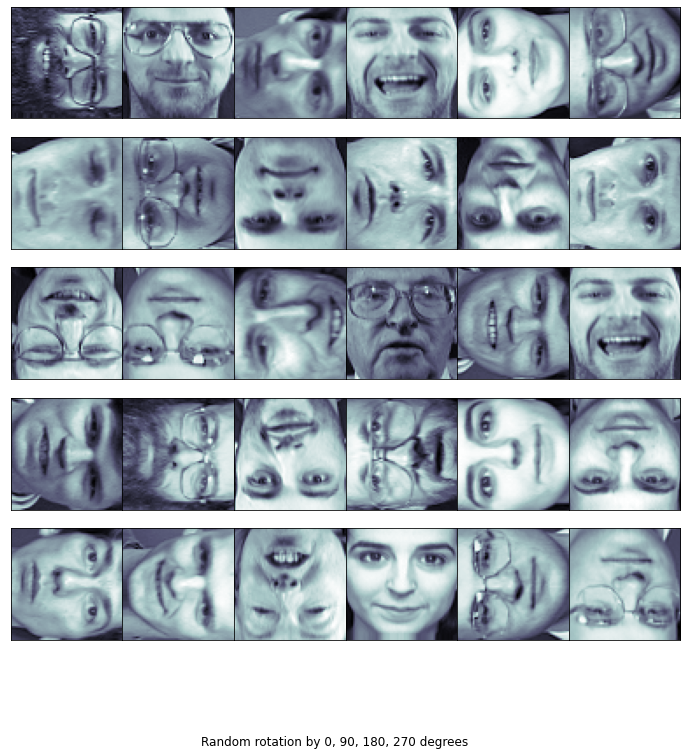

In [243]:
images_to_view = np.random.choice(400, (5, 6))
images_to_view_grid_dict = {(i, j): X[:, images_to_view[i, j]]
                            for i in range(5) for j in range(6)}

display_images_in_grid(m=5,
                       n=6,
                       fig_size=(12, 12),
                       img_dict=images_to_view_grid_dict,
                       reshape_size=(64, 64),
                       xlabel='Random rotation by 0, 90, 180, 270 degrees',
                       ylabel='')

The image grid below is set out as above for the non-rotated images, showing how the reduced image compares to the original for a given number of reduced dimensions. It actually does quite well. Not quite as good I think as the original set, but with 100 dimensions there is a definite resemblance.

In [244]:
mu, sigma, X_norm, evalues, evectors = get_pca(X)

In [245]:
reduced_dims = [5, 10, 20, 50, 100]
X_reduced = [
    get_reduced_pca_representation(mu, sigma, X_norm, evalues, evectors, m=d)
    for d in reduced_dims
]

X_orig_plus_reduced = [X] + X_reduced

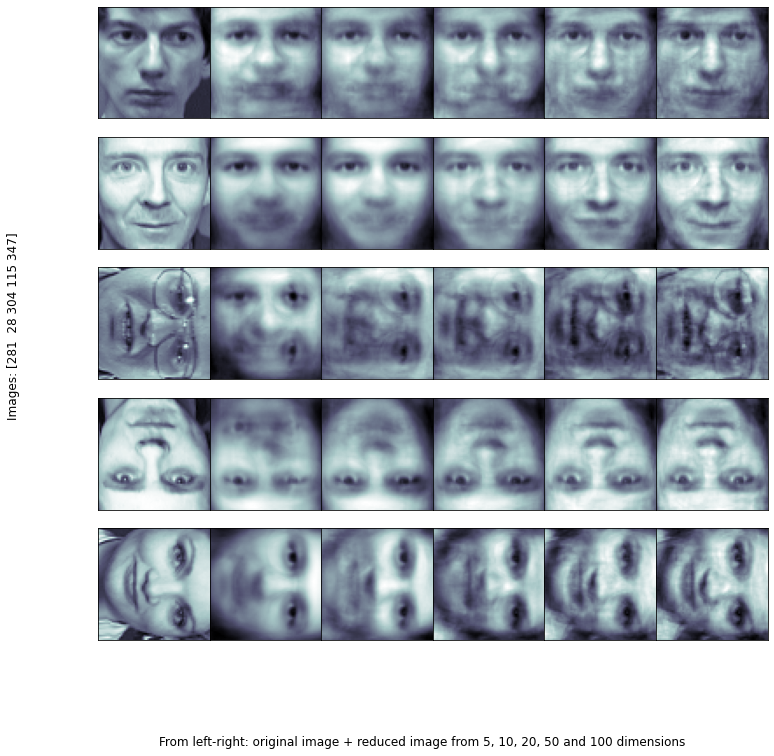

In [246]:
# take 5 random ones from the 400
images_to_view = np.random.choice(400, 5)
images_to_view_grid_dict = {(i, j): X_orig_plus_reduced[j][:,
                                                           images_to_view[i]]
                            for i in range(5) for j in range(6)}

display_images_in_grid(
    m=5,
    n=6,
    fig_size=(12, 12),
    img_dict=images_to_view_grid_dict,
    reshape_size=(64, 64),
    xlabel='From left-right: original image + reduced image from 5, 10, 20, 50 and 100 dimensions',
    ylabel=f'Images: {images_to_view}')

We can also view the Eigenvectors / Rorschach ink blots.

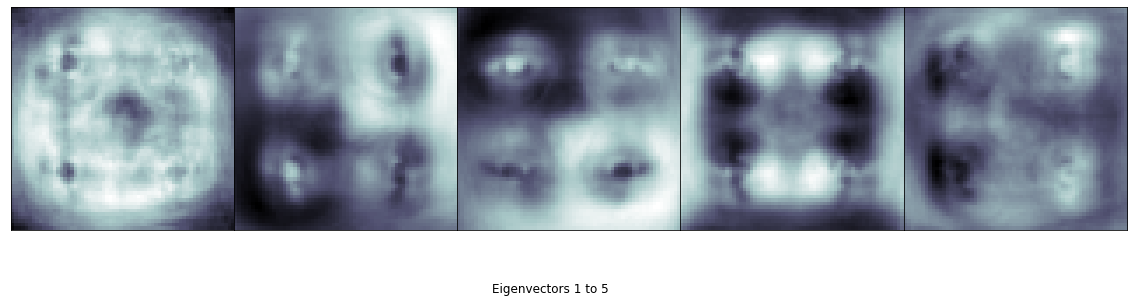

In [247]:
evectors_1_to_5_grid_dict = {(0, j): evectors[:, j] for j in range(5)}

display_images_in_grid(m=1,
                       n=5,
                       fig_size=(20, 5),
                       img_dict=evectors_1_to_5_grid_dict,
                       reshape_size=(64, 64),
                       xlabel='Eigenvectors 1 to 5',
                       ylabel='')

# Eigen digits

Try the same approach on the digits dataset.

In [248]:
print(datasets.load_digits().DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

Do the PCA decomposition and get a reduced representation.

In [249]:
X = np.transpose(datasets.load_digits().data)
print(f'Dimensions of dataset: {X.shape}')
print(f'Number of images     : {X.shape[1]}')
mu, sigma, X_norm, evalues, evectors = get_pca(X)

Dimensions of dataset: (64, 1797)
Number of images     : 1797


In [250]:
reduced_dims = [1, 2, 4, 8, 16]
X_reduced = [
    get_reduced_pca_representation(mu, sigma, X_norm, evalues, evectors, m=d)
    for d in reduced_dims
]

X_orig_plus_reduced = [X] + X_reduced

See how the original fares vs. the reconstructed datasets.

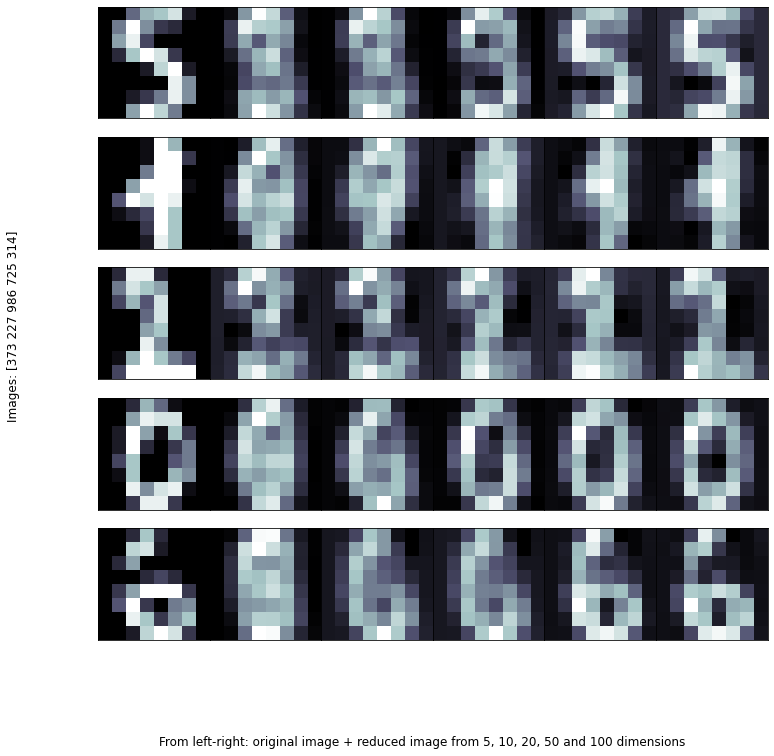

In [251]:
# take 5 random ones from the 1797
images_to_view = np.random.choice(1797, 5)
images_to_view_grid_dict = {(i, j): X_orig_plus_reduced[j][:,
                                                           images_to_view[i]]
                            for i in range(5) for j in range(6)}

display_images_in_grid(
    m=5,
    n=6,
    fig_size=(12, 12),
    img_dict=images_to_view_grid_dict,
    reshape_size=(8, 8),
    xlabel='From left-right: original image + reduced image from 5, 10, 20, 50 and 100 dimensions',
    ylabel=f'Images: {images_to_view}')

And the first 5 Eigenvectors.

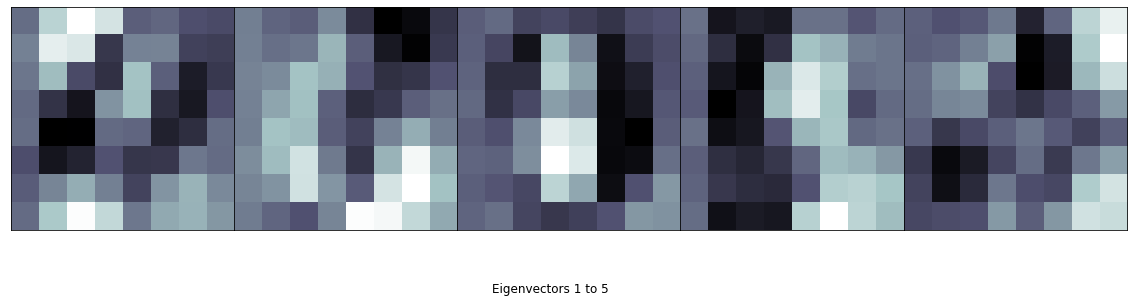

In [252]:
evectors_1_to_5_grid_dict = {(0, j): evectors[:, j] for j in range(5)}

display_images_in_grid(m=1,
                       n=5,
                       fig_size=(20, 5),
                       img_dict=evectors_1_to_5_grid_dict,
                       reshape_size=(8, 8),
                       xlabel='Eigenvectors 1 to 5',
                       ylabel='')

# Eigen curve (changes)

The Bank of England provides historical yield curve data here: https://www.bankofengland.co.uk/statistics/yield-curves.

The CSV below contains the daily curve changes for maturities of 1 year to 40 years, at half-yearly intervals, between 2016 and the present. Note since the data is provided in an Excel format, there are a few pre-processing steps to get to the CSV below i.e.
- remove any rows without incomplete data from t=1 to t=40
- remove excess/empty rows and columns
- calculate the differences

Not quite daily yield curve changes owing to weekends and bank holidays, but close enough. As before, we can apply the PCA decompoisition.

In [253]:
import pandas as pd

df = pd.read_csv('GLC Nominal daily data_2016 to present - curve changes.csv', index_col=0)
X = np.transpose(np.array(df))

print(f'Dimensions of dataset: {X.shape}')
print(f'Number of yield curve changes: {X.shape[1]}')

Dimensions of dataset: (79, 1788)
Number of yield curve changes: 1788


In [254]:
mu, sigma, X_norm, evalues, evectors = get_pca(X)

## Level, slop and curvature

We can plot the first three Eigenvectors; these are generally known as level, slope and curvature. These are the main drivers for interest changes, and as such are reflected in the first three principal components.

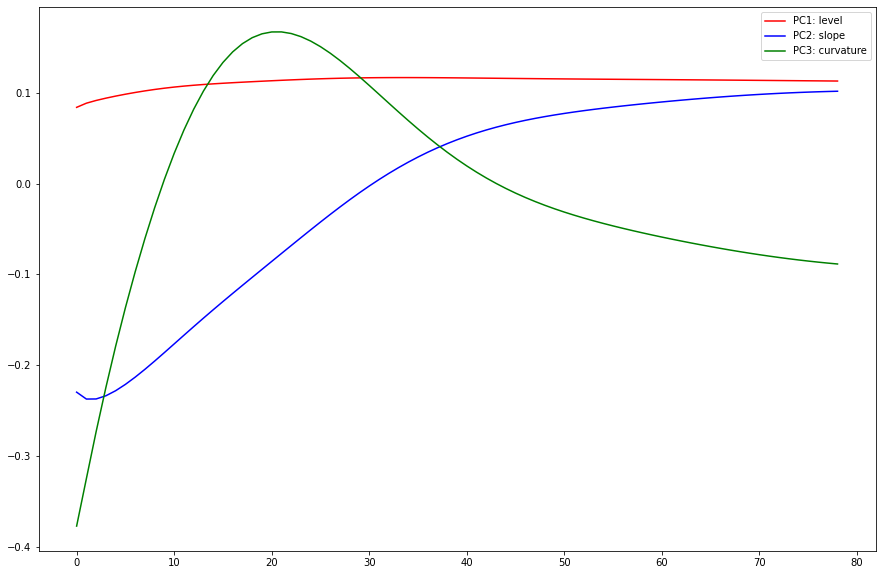

In [255]:
plt.plot(evectors[:,0],'r-',label='PC1: level')
plt.plot(evectors[:,1],'b-',label='PC2: slope')
plt.plot(evectors[:,2],'g-',label='PC3: curvature')
plt.legend()
plt.show()

These three together account for much of the variance.

variance explained with PC1:     91.26%
variance explained with PC1+2:   98.34%
variance explained with PC1+2+3: 99.58%


Text(0.5, 1.0, 'Variance explained as function of principal components')

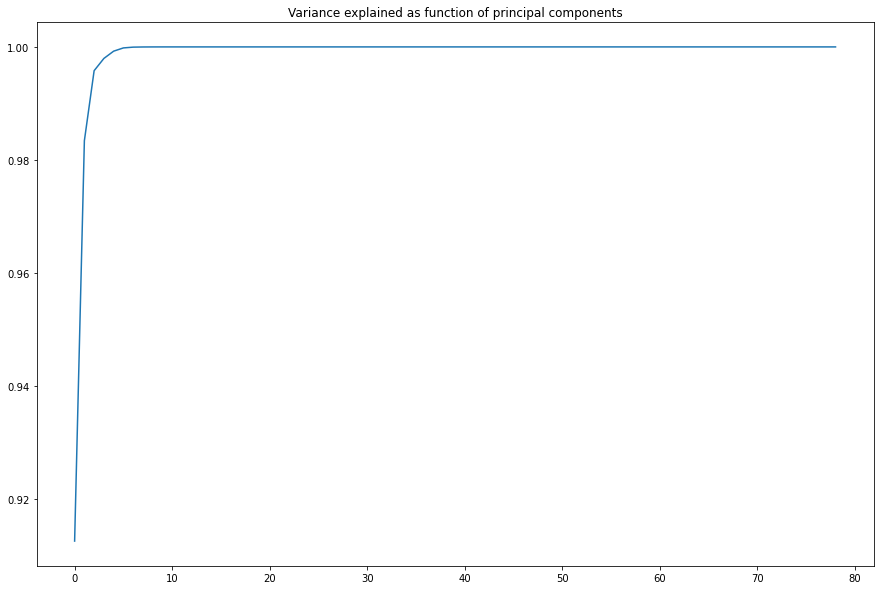

In [256]:
variance_explained = evalues.cumsum()[:10]/79
print(f'variance explained with PC1:     {variance_explained[0]:.2%}')
print(f'variance explained with PC1+2:   {variance_explained[1]:.2%}')
print(f'variance explained with PC1+2+3: {variance_explained[2]:.2%}')

plt.plot(evalues.cumsum()/79)
plt.title('Variance explained as function of principal components')

In [257]:
reduced_dims = [1, 2, 3, 4]
X_reduced = [
    get_reduced_pca_representation(mu, sigma, X_norm, evalues, evectors, m=d)
    for d in reduced_dims
]

X_orig_plus_reduced = [X] + X_reduced

For a given data point we can re-construct the curve, demonstrating how incremental components comprise the complete curve.

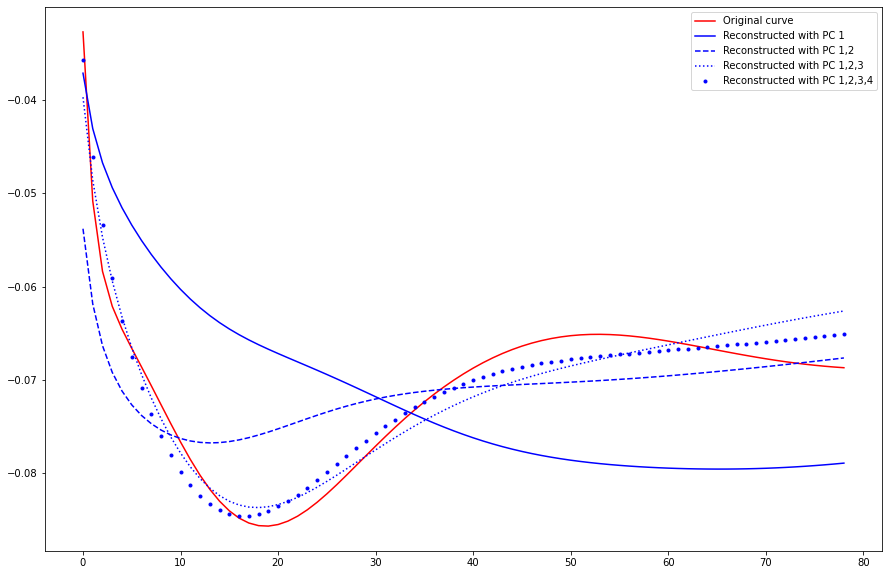

In [258]:
# pick an index and visualise the reduced representation
idx = 1

plt.rcParams["figure.figsize"]=15,10
plt.plot(X[:,idx],'r-',label='Original curve')
plt.plot(X_reduced[0][:,idx],'b-', label='Reconstructed with PC 1')
plt.plot(X_reduced[1][:,idx],'b--',label='Reconstructed with PC 1,2')
plt.plot(X_reduced[2][:,idx],'b:', label='Reconstructed with PC 1,2,3')
plt.plot(X_reduced[3][:,idx],'b.', label='Reconstructed with PC 1,2,3,4')
plt.legend()
plt.show()